Grade: 6

# SLT-CE-2: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [1]:
!pip install scikit-learn
!pip install scikit-image
!pip install scipy
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install jupyter
!pip install tensorflow
!pip install treelib
!pip install pathos
!pip install pandas
!pip install matplotlib
!pip install tqdm



  Created wheel for treelib: filename=treelib-1.6.1-cp37-none-any.whl size=18370 sha256=9653daaa5d7c4af06e5d6116279e83ac0b3ef4c8edc4bef4219d26624c3af8c5
  Stored in directory: /root/.cache/pip/wheels/68/1d/92/c50ec52951ccebafb40f3b8f0beb28fbaf745431c14a17c497
Successfully built treelib
     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 71kB 4.4MB/s 


In [2]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [11]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

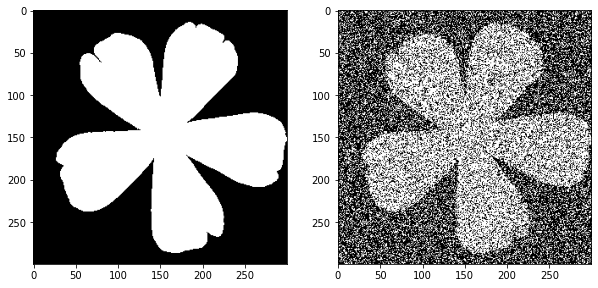

In [12]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: The Metropolis algorithm is an algorithm that performs MCMC sampling using the Metropolis Hastings trick, where the proposal distributions $\lbrace q(\cdot | c) | c \in \mathcal{C}\rbrace$ are symmetrical: $q(c | c' ) = q(c' | c)$. The Metropolis-Hastings trick provides a way of finding a transition distribution $\pi (\cdot | c)$ that satisfies a given set of conditions for the MCMC algorithm. The transition distribution in the metropolis algorith is then as follows:
$ \pi(c' | c):= q(c' | c ) A(c',c)$ $if$ $c\neq c'$ $and$ $ \pi(c' | c):= 1 - \sum_{c' \neq c} q(c' | c ) A(c',c)$ $otherwise$. Here $A(c',c):=\min \left\lbrace 1, \frac{p(c')}{p(c)} \right\rbrace$ is the acceptance probability: the proabability of accepting a transition from $c$ to $c'$ where $c'$ was proposed according to the above mentioned symmetrical proposal distribution $q(c' | c )$, and $p(\cdot )$ is the stationary distribution. The algorithm is then as folows: you start at an arbitrary sample $c$ and then iteratively transition to other samples according to the above proposal distribution and the transition distribution.

- **Metropolis-Hastings**: The Metropolis-Hastings algorithm is like the Metropolis algorithm except that while the proposal distribution $ q(c' | c ) $ in the Metropolis algoirhtm is symmetrical, the same does not hold for the Metropolis-Hastings algorithm. Like in the Metropolis algorithm, the Metropolis-Hastings algorithm is based on the transition distribution $ \pi(c' | c):= q(c' | c ) A(c',c)$ $if$ $c\neq c'$ $and$ $ \pi(c' | c):= 1 - \sum_{c' \neq c} q(c' | c ) A(c',c)$ $otherwise$, however now the acceptance probability is different:  $A(c',c):=\min \left\lbrace 1, \frac{q(c|c')p(c')}{q(c'|c)p(c)} \right\rbrace$. Like in the Metropolis algorithm, the Metropolis-Hastings algorithm is then as folows: you start at an arbitrary sample $c$ and then iteratively transition to other samples according to the above proposal distribution and the transition distribution.




    

- **Simulated Annealing**: In the Metropolis-Hastings sampling procedure for sampling of the Gibbs distribution it was found that the temperature hyperparameter $T$ in the gibbs distribution $p(c|X)\propto \exp(-\frac{1}{T} R(c,X))$ has a great influence on how long it takes for the procedure to converge.  More specifically it is presented in the lecture that if $T$ is too small then it takes the procedure "too long" to converge because it gets stuck in local minimas, and if it is too large then it is hard for the algorithm to discriminate between good and bad solutions. The Simulated Annealing algorithm builds on the Metropolis-Hastings (or the Metropolis) algorithm with the one contribution being the combatting of the just now mentioned issue. This is done by gradually decreasing $T$ as the Metropolis Hasting algorithm is being run. This has been shown to help the procedure escape local minimas and converge towards the global minima.

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [14]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    x = img_estimate
    y = img_noisy_observation
    
    E = 0
    N = 4 #as described in the exercise (what about the pixels on the edges??)
    
    for i in range(height):
        for j in range(width):
            if i != img_estimate.shape[0]-1:
                E+=-(beta/2)*(x[i,j]/N)*x[i+1,j]
            if i != 0: 
                E+=-(beta/2)*(x[i,j]/N)*x[i-1,j]
            if j != img_estimate.shape[1]-1:
                E+=-(beta/2)*(x[i,j]/N)*x[i,j+1]
            if j != 0: 
                E+=-(beta/2)*(x[i,j]/N)*x[i,j-1]
            E+= - mu*x[i,j]*y[i,j]
    return E 
def energy_i(img_noisy_observation, img_estimate, k, l, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    x = img_estimate
    y = img_noisy_observation
    
    E = 0
    N = 4 #as described in the exercise (what about the pixels on the edges??)
    
    for i in range(height):
        for j in range(width):
            if i != img_estimate.shape[0]-1 and i == k and j ==l:
                E+=-(beta/2)*(x[i,j]/N)*x[i+1,j]
            if i != 0 and i == k and j ==l: 
                E+=-(beta/2)*(x[i,j]/N)*x[i-1,j]
            if j != img_estimate.shape[1]-1 and i == k and j ==l:
                E+=-(beta/2)*(x[i,j]/N)*x[i,j+1]
            if j != 0 and i == k and j ==l: 
                E+=-(beta/2)*(x[i,j]/N)*x[i,j-1]
            E+= - mu*x[i,j]*y[i,j]
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [15]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [16]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            i, j = np.unravel_index(idx, estimate.shape)
            
            
            estimate_check = estimate.copy()
            estimate_check[i,j] = -1*estimate_check[i,j]
            
            """
            energy_check = energy(noisy_img, estimate_check)
            energy_prev = energy(noisy_img, estimate)
            if energy_check < energy_prev:
                estimate = estimate_check
            """
            
                
            
            beta = 1/T
            A = np.minimum(1, np.exp(-beta*(energy(noisy_img, estimate_check)-energy(noisy_img,estimate))))
            
            q = 1
            
            transition_probability = q*A
            
            rand = np.random.uniform() #random number between 0 and 1
            if rand < transition_probability:
                estimate=estimate_check
            
                
            
    
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [17]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

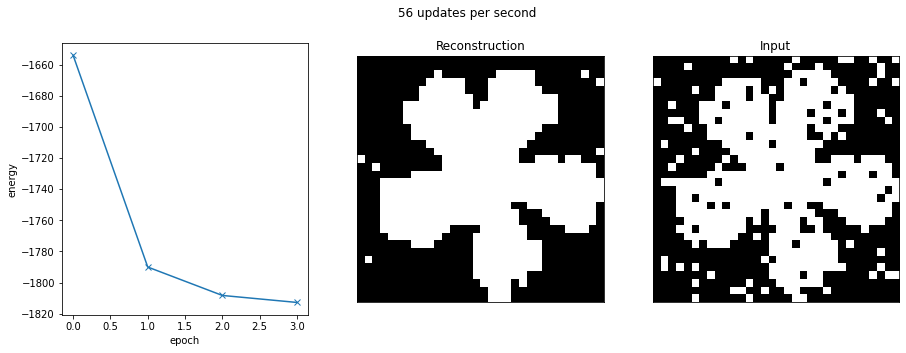

In [30]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

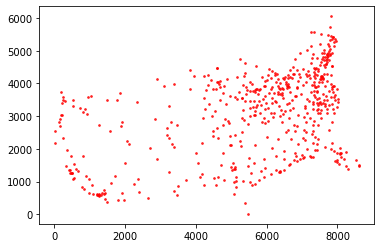

In [18]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [19]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
    dist = 0

    if route is not None:
        coordinates = coordinates[route]

    for i in range(coordinates.shape[0]):
        dist += np.linalg.norm(coordinates[i-1,:] - coordinates[i,:])
    return dist/1000

New distance strategy to reduce strategy

In [20]:
def distance_change(coordinates, idx, route):
    """
    if route is not None:
        coordinates = coordinates[route]
    """
    route_changed = route.copy()
    temp = route_changed[idx-1]
    route_changed[idx-1] = route_changed[idx-2]
    route_changed[idx-2] = temp
    
    
    del temp
    coordinates_changed = coordinates.copy()
    coordinates = coordinates[route]
    coordinates_changed = coordinates_changed[route_changed]
    
    dchanged = 0
    dunchanged = 0
    for i in range(3):
        dchanged += np.linalg.norm(coordinates_changed[idx-3+i,:] - coordinates_changed[idx-2+i,:])
        dunchanged += np.linalg.norm(coordinates[idx-3+i,:] - coordinates[idx-2+i,:])
    dD = dchanged - dunchanged
    return dD/1000

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [21]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [22]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")
        

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [23]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)

    
    distances = []
    distances.append(distance(coordinates, route))

    for e in tqdm(range(epochs)):

        #"""
        for idx_plus in np.random.permutation(N):
            #idx_plus : the index after the indexes that are flipped 
            dD = distance_change(coordinates, idx_plus, route)
            A = np.minimum(1, np.exp(-(1/T)*(dD)))
            rand = np.random.uniform()
            if rand<A:
                temp = route[idx_plus-1].copy()
                route[idx_plus-1] = route[idx_plus-2]
                route[idx_plus-2] = temp
                del temp
        distances.append(distance(coordinates, route))
        #"""
            

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

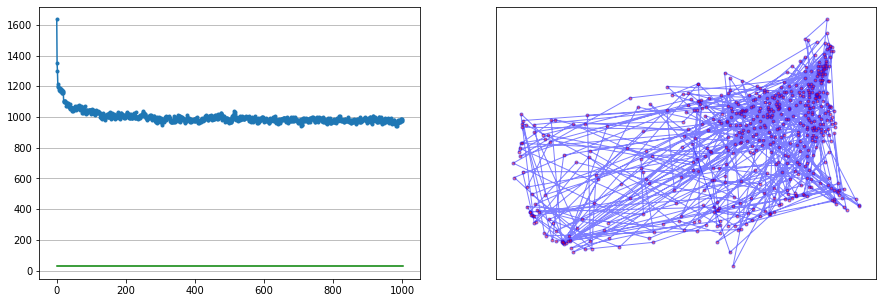

In [24]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [25]:
def acceptance_probability(route1, route2, T, coordinates):
    beta = 1/T
    A = np.minimum(1, np.exp(-beta*(distance(coordinates, route2)-distance(coordinates, route1))))
    return A
                      

def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    T_init = T
    distances = []
    distances.append(distance(coordinates, route))
    n = 0
    for e in tqdm(range(epochs)):

        #"""
        for idx_plus in np.random.permutation(N):
            #idx_plus : the index after the indexes that are flipped 
            dD = distance_change(coordinates, idx_plus, route)
            A = np.minimum(1, np.exp(-(1/T)*(dD)))
            
            rand = np.random.uniform()
            if rand<A:
                temp = route[idx_plus-1]
                route[idx_plus-1] = route[idx_plus-2]
                route[idx_plus-2] = temp
                del temp
        n += 1
        T = T_init * eta**n
        distances.append(distance(coordinates, route))
        #"""

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

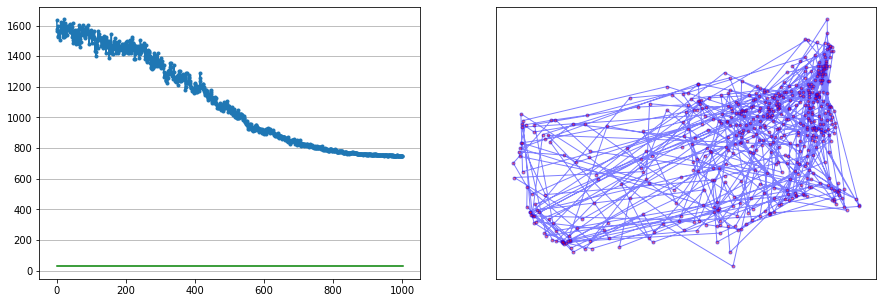

In [26]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [27]:
def local_energy(noisy, estimate, i, j, beta, mu):
    N=4
    E=0
    height = estimate.shape[0]
    width = estimate.shape[1]
    x = estimate
    y = noisy

    E+= -beta*x[i,j]*( (x[i+1,j] if i != height-1 else 0)+(x[i-1,j] if i != 0 else 0) 
                      + (x[i,j+1] if j != width-1 else 0 ) + (x[i,j-1] if j != 0 else 0) ) / N
    E+= - mu*x[i,j]*y[i,j]
    return E
    
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """ 
    E_unflipped = 0
    E_flipped = 0
    N = 4 #as described in the exercise (what about the pixels on the edges??)
    estimate_check = estimate.copy()
    estimate_check[i,j] = -1 * estimate_check[i,j]
    
    E_unflipped = local_energy(noisy, estimate, i, j, beta, mu)
    E_flipped = local_energy(noisy, estimate_check, i, j, beta, mu)

    dE = E_unflipped - E_flipped

    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []

    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            
            
            i, j = np.unravel_index(pix, estimate.shape)
            


            """
            dE = local_energy_change(noisy_img, estimate, i, j, beta, mu)

            if dE>0:
                estimate[i,j] = -1 * estimate[i,j] 
            """
            estimate_check = estimate.copy()
            estimate_check[i,j] = -1*estimate_check[i,j]
            A = np.minimum(1, np.exp(-(1/T)*(-1*local_energy_change(noisy_img, estimate, i, j, beta, mu))))

            
            rand = np.random.uniform() #random number between 0 and 1
            
            if rand < A*1:
                estimate[i,j] = -1 * estimate[i,j]
            
 
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
    
  
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

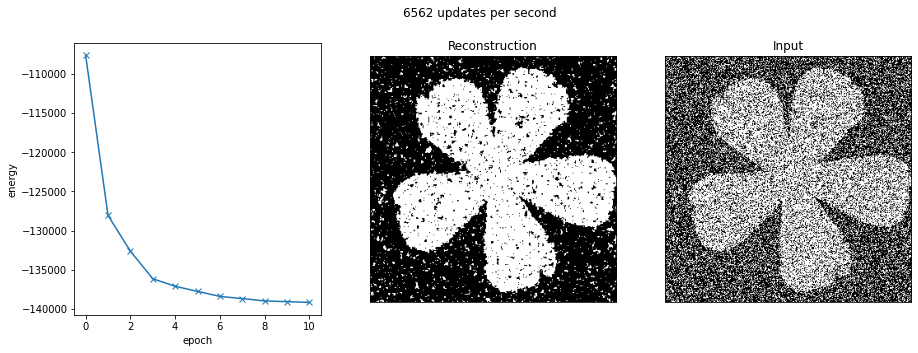

(-139178.75, 0.0736)

In [28]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [31]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [33]:
def checkerboard_energy(y_, x_, g, beta, mu, width, height):
    
    N=4
    x = np.reshape(x_, (height,width))    
    x_pad = np.pad(x, ((1,1),(1,1)), 'constant')
    
    kernel = np.array([[0,1,0], [1,0,1], [0,1,0]])
    conv = fftconvolve(x_pad, kernel, mode='same')
    conv = np.reshape(conv[1:-1, 1:-1], [-1])
    conv = conv[g]
    E = -(beta)*(conv * x_[g])/N    
    E+=-mu*x_[g]*y_[g]

    return E

def checkerboard_energy_change(noisy_img, estimate, grid_raveled, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: ((Flat array or)) -> list of grid indices <-.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    
    
    width = estimate.shape[1]
    height = estimate.shape[0]
    noisy_img_ = np.reshape(noisy_img, [-1])
    estimate_ = np.reshape(estimate, [-1])
    estimate_flipped_ = estimate_.copy()
    estimate_flipped_[grid_raveled] = -1 * estimate_flipped_[grid_raveled]


    E_unflipped = checkerboard_energy(noisy_img_, estimate_, grid_raveled, beta, mu, width, height)
    E_flipped = checkerboard_energy(noisy_img_, estimate_flipped_, grid_raveled, beta, mu, width, height)
   
    dE = E_unflipped - E_flipped

    
    return dE

In [34]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    estimate_ = np.reshape(estimate.copy(), [-1])
    estimate_x = np.reshape(estimate_, estimate.shape)
    height = estimate.shape[0]
    width = estimate.shape[1]
    grid1_raveled = []
    grid2_raveled = []
    
    l=0
    for k in range(height):
        for i in range(0, width, 2):
            if k%2==0:
                j = 0
            else:
                j = 1
            grid1_raveled.append(l+j)
            grid2_raveled.append(l+1-j)
            l+=2
        
    grids_raveled = [grid1_raveled, grid2_raveled]

    energies = []
    for e in range(epochs):
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        for grid_raveled in grids_raveled:
            
            energy_map = checkerboard_energy_change(noisy_img, estimate, grid_raveled, beta, mu)
            
            A = np.minimum(np.ones(energy_map.shape), np.exp(-(1/T)*(-energy_map)))

            rand = np.random.uniform(size=A.shape) 
            
            flip_idx_of_grid = np.where((rand < A)==True)[0]
            
            grid_raveled_array = np.array(grid_raveled)
            flip_idx = list(grid_raveled_array[list(flip_idx_of_grid)])
            estimate_[flip_idx] = -1 * estimate_[flip_idx]
            
            estimate = np.reshape(estimate_, estimate.shape)               
            
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

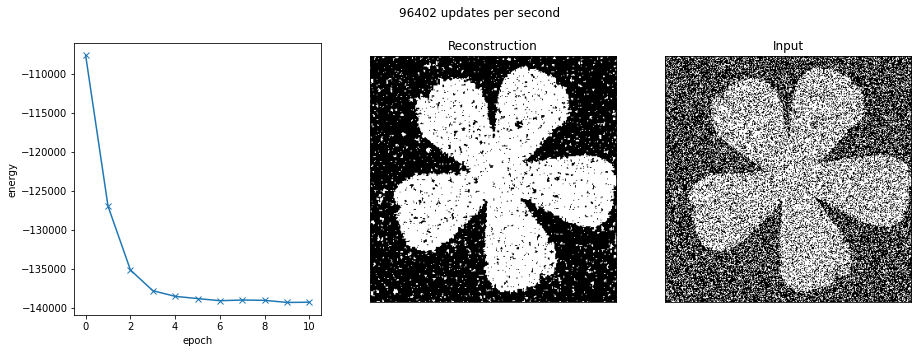

(-139230.25, 0.06993333333333333)

In [35]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

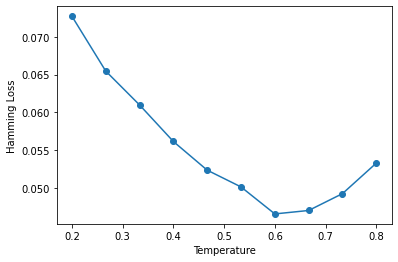

In [36]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

When sampling from the gibs distribution it was presented in the lecture that the Metropolis-Hasting algorithm struggles both when the temperature T is too high and too low. When T is too high, then the algorithm performs random walks too frequently and so it does not settle near a globally optimal solution. When T is too small, on the other hand, the algorithm gets stuck in local minimas and so it struggles to reach a globally optimal solution. As a result, as seen in the Hamming Loss -- Temperature plot, the optimal choice of Temperature lies between T being large and small.

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

i


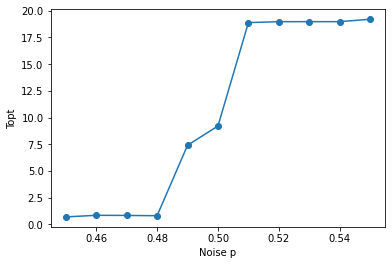

In [37]:
def find_Topt(p):
    import matplotlib.image as mpimg
    import numpy as np
    import pandas as pd
    import matplotlib.pylab as plt
    import time

    from skimage.transform import resize
    from scipy.signal import fftconvolve
    from sklearn.metrics import hamming_loss

    from scipy.optimize import minimize_scalar
    from multiprocessing import cpu_count
    from pathos.multiprocessing import ProcessingPool as Pool

    import warnings
    warnings.filterwarnings('ignore')
    
    
    def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
        """ Given a sampling method, we will run the sampling procedure 
        for the specifed number of epochs. We measure time and reconstruction
        efficiency.

        Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
            T (float): The positive temperature of the simulation
        """

        start_time = time.time()
        img_estimate, energies = method(img_noisy_observation, epochs, T)
        execution_time = time.time() - start_time

        if not surpress:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

            ax1.plot(energies, marker="x")
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('energy')

            ax2.imshow(img_estimate, cmap='gray')
            ax2.set_title('Reconstruction')
            ax2.get_xaxis().set_visible(False)
            ax2.get_yaxis().set_visible(False)

            ax3.imshow(img_noisy_observation, cmap='gray')
            ax3.set_title('Input')
            ax3.get_xaxis().set_visible(False)
            ax3.get_yaxis().set_visible(False)

            plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

            plt.show()

        return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())
    def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
        """Metropolis sampling

        Alternatingly update two independent grids

        Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            epochs (int): number of rounds over all pixels

        Returns:
            img_estimate (np.ndarray): reconstucted image estimate
            energies (np.ndarray): energy after each epoch
        """
        np.random.seed(7) # Always set the random seed to a lucky number

        n_pixels = img_noisy_observation.size

        noisy_img = img_noisy_observation.copy()
        estimate = img_noisy_observation.copy()
        estimate_ = np.reshape(estimate.copy(), [-1])
        estimate_x = np.reshape(estimate_, estimate.shape)
        height = estimate.shape[0]
        width = estimate.shape[1]
        grid1_raveled = []
        grid2_raveled = []

        l=0
        for k in range(height):
            for i in range(0, width, 2):
                if k%2==0:
                    j = 0
                else:
                    j = 1
                grid1_raveled.append(l+j)
                grid2_raveled.append(l+1-j)
                l+=2




        grids_raveled = [grid1_raveled, grid2_raveled]

        energies = []
        for e in range(epochs):
            if e == 0:
                energies.append(energy(noisy_img, estimate))
            for grid_raveled in grids_raveled:

                energy_map = checkerboard_energy_change(noisy_img.copy(), estimate.copy(), grid_raveled, beta, mu)

                A = np.minimum(np.ones(energy_map.shape), np.exp(-(1/T)*(-energy_map)))

                rand = np.random.uniform(size=A.shape) 

                estimate_[[grid_raveled[i] for i in list(np.where((rand < A)==True)[0])]] = -1*estimate_[[grid_raveled[i] for i in list(np.where((rand < A)==True)[0])]]   
                estimate = np.reshape(estimate_.copy(), estimate.shape)



            print("Finished epoch {}".format(e+1), end="\r")
            energies.append(energy(noisy_img, estimate))

        return estimate, np.asarray(energies)
    def flower(size=None, p=0.3):
        """Load image data for denoising

        Args:
            size (tuple): image size, default (300,300)
            p (float): noise fraction in [0,1]

        Returns:
            noisy: noisy image
            img: ground truth image
        """
        img = mpimg.imread("flower.png") # Load image

        # Binarize image
        img[img > 0.5] = 1
        img[img <= 0.5] = -1

        # Resize image 
        if size is not None:
            img = resize(img, size)
            img[img > 0] = 1
            img[img <= 0] = -1

        np.random.seed(13)

        flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

        noisy = flip * img

        return noisy, img
    
    def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
        """Compute the energy for given estimate 'img_estimate' which
        is our vector x in the original model, with respect to the 
        observation 'img_noisy_observation', which corresponds to the vector y in the model.

        Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

        Returns:
            energy (float): energy of the estimate given observation
        """
        height = img_estimate.shape[0]
        width = img_estimate.shape[1]

        x = img_estimate
        y = img_noisy_observation

        E = 0
        N = 4 #as described in the exercise (what about the pixels on the edges??)

        for i in range(height):
            for j in range(width):
                if i != img_estimate.shape[0]-1:
                    E+=-(beta/2)*(x[i,j]/N)*x[i+1,j]
                if i != 0: 
                    E+=-(beta/2)*(x[i,j]/N)*x[i-1,j]
                if j != img_estimate.shape[1]-1:
                    E+=-(beta/2)*(x[i,j]/N)*x[i,j+1]
                if j != 0: 
                    E+=-(beta/2)*(x[i,j]/N)*x[i,j-1]
                E+= - mu*x[i,j]*y[i,j]
        return E 
    def energy_i(img_noisy_observation, img_estimate, k, l, beta=2.5, mu=1):
        """Compute the energy for given estimate 'img_estimate' which
        is our vector x in the original model, with respect to the 
        observation 'img_noisy_observation', which corresponds to the vector y in the model.

        Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

        Returns:
            energy (float): energy of the estimate given observation
        """
        height = img_estimate.shape[0]
        width = img_estimate.shape[1]

        x = img_estimate
        y = img_noisy_observation

        E = 0
        N = 4 #as described in the exercise (what about the pixels on the edges??)

        for i in range(height):
            for j in range(width):
                if i != img_estimate.shape[0]-1 and i == k and j ==l:
                    E+=-(beta/2)*(x[i,j]/N)*x[i+1,j]
                if i != 0 and i == k and j ==l: 
                    E+=-(beta/2)*(x[i,j]/N)*x[i-1,j]
                if j != img_estimate.shape[1]-1 and i == k and j ==l:
                    E+=-(beta/2)*(x[i,j]/N)*x[i,j+1]
                if j != 0 and i == k and j ==l: 
                    E+=-(beta/2)*(x[i,j]/N)*x[i,j-1]
                E+= - mu*x[i,j]*y[i,j]
        return E 
    
    def checkerboard_energy(y_, x_, g, beta, mu, width, height):
    
        N=4
        up = -width
        down = width
        left = -1
        right = 1
        x = np.reshape(x_, (height,width))
        y = np.reshape(y_, (height,width))

        x_i_ = x_.copy()
        x_i_ = np.append(x_i_, 0)


        x_down = x_i_[[(u+down if u < width*(height-1) else -1) for u in g]]
        x_up = x_i_[[(u+up if u > (width-1) else -1) for u in g]] 
        x_right = x_i_[[( u+right if u % width != width - 1 else -1)  for u in g]]
        x_left = x_i_[[( u+left if u % width != 0 else -1)  for u in g]]

        E =  -(beta*np.multiply(x_[g],( x_down+ x_up + x_right + x_left )) / N) - mu*x_[g]*y_[g]
        return E

    def checkerboard_energy_change(noisy_img, estimate, grid_raveled, beta, mu):
        """Compute energy change when flipping pixels in grid

        When using the 4-neighborhood, a 2D image can be separated in two
        independent grids, hence the name checkerboard.
        All the pixels in one grid can be updated simultaneously, because they
        are independent. Using this property, we can improve computational
        efficiency by using vectorized operations instead of loops.

        Args:
            noisy_img: Noisy reference image
            estimate: Current image reconstruction
            grid: ((Flat array or)) -> list of grid indices <-.

        Returns:
            numpy.array: Energy change for each pixel in grid,
                same size as grid.

        """


        width = estimate.shape[1]
        height = estimate.shape[0]
        noisy_img_ = np.reshape(noisy_img.copy(), [-1])
        estimate_ = np.reshape(estimate.copy(), [-1])
        estimate_flipped_ = estimate_.copy()
        estimate_flipped_[grid_raveled] = -1 * estimate_flipped_[grid_raveled]


        E_unflipped = checkerboard_energy(noisy_img_, estimate_, grid_raveled, beta, mu, width, height)
        E_flipped = checkerboard_energy(noisy_img_, estimate_flipped_, grid_raveled, beta, mu, width, height)

        dE = E_unflipped - E_flipped


        return dE
    
    
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x
print('i')
prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

The above graph presents that when the amount of noise in the image is relateively small then the optimal Temperature is also relatively small and if the noise is relatively large then the optimal Temperature is also relatively large. What this suggests is that when there a lot of noise, to denoise the image it is more important to perform random walks than it is when the noise is small. Intuitivelly this makes sense, because when the noise is already small, it it is already close to the global minima, and so it is undesirable to perform a lot of random walks which might make the image more noisy than it already is. On the other hand, when the image is very noisy, random walks are more needed in order to get closer to the global minima. Without random walks the algorithm would be expected to get stuck in local minimas.

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [7]:
def distance_change_fancy(coordinates, idx_plus, k, range_swap, route):
    #k in [-2, -1, 1, 2]
    
    idx_swap = idx_plus-range_swap-1
    idx_swap_target = idx_swap+k
    
    route_changed = route.copy()
    temp = route_changed[idx_swap]
    route_changed[idx_swap] = route_changed[idx_swap_target]
    route_changed[idx_swap_target] = temp
    
    del temp
    coordinates_changed = coordinates.copy()
    coordinates = coordinates[route]
    coordinates_changed = coordinates_changed[route_changed]
    
    dchanged = 0
    dunchanged = 0
    """
    for i in range(range_swap*2-1):
            
        dchanged += np.linalg.norm(coordinates_changed[idx_plus-range_swap*2+i,:] - coordinates_changed[idx_plus-range_swap*2-1+i,:])
        dunchanged += np.linalg.norm(coordinates[idx_plus-range_swap*2+i,:] - coordinates[idx_plus-range_swap*2-1+i,:])
    """
    for i in range(np.absolute(k)+2):
        if k>0:
            dchanged += np.linalg.norm(coordinates_changed[idx_swap-1+i,:] - coordinates_changed[idx_swap+i,:])
            dunchanged += np.linalg.norm(coordinates[idx_swap-1+i,:] - coordinates[idx_swap+i,:])
        if k<0:
            dchanged += np.linalg.norm(coordinates_changed[idx_swap+k-1+i,:] - coordinates_changed[idx_swap+k+i,:])
            dunchanged += np.linalg.norm(coordinates[idx_swap+k-1+i,:] - coordinates[idx_swap+k+i,:])
    
        
    dD = dchanged - dunchanged
    return dD/1000

In [8]:
def simulated_annealing_fancy(coordinates, range_swap, route=None, epochs=1, T=20.0, eta=0.995):
    np.random.seed(7)
    N = coordinates.shape[0]

    T_init = T
    distances = []
    distances.append(distan ce(coordinates, route))
    n = 0
    k = []
    k_ = []

    for i in range(range_swap):
        k.append(i+1)
        k_.append(-1 * (i+1))

    k_=list(reversed(k_))
    k = k_+k

    for e in tqdm(range(epochs)):
        for idx_plus in np.random.permutation(N):
            #"""
            dDs = []
            for i in range(range_swap*2):
                dDs.append(distance_change_fancy(coordinates, idx_plus, k[i], range_swap, route))
            
            prob_distrib = [np.exp(-3*i) for i in dDs]
            prob_sum = sum(prob_distrib)
            prob_distrib = [i/prob_sum for i in prob_distrib]
            k_i = np.random.choice(k, p=prob_distrib)
            #"""
            #k_i = np.random.choice(k)
            dD = distance_change_fancy(coordinates, idx_plus, k_i, range_swap, route)
            A = np.minimum(1, np.exp(-(1/T)*(dD)))
            rand = np.random.uniform()
            if rand<A:
                idx_swap = idx_plus-range_swap-1
                idx_swap_target = idx_swap+k_i
                
                temp = route[idx_swap]
                route[idx_swap] = route[idx_swap_target]
                route[idx_swap_target] = temp
                del temp
        n += 1
        T = T_init * eta**n
        distances.append(distance(coordinates, route))
        if e %20 == 0:
            print(distances[-1])

    return np.asarray(route), np.asarray(distances)

In [9]:
def myfancyalgorithm(coordinates, route=None, epochs=1):
    
    np.random.seed(7)
    range_swap = 50
    
    if route is None:
        route = np.random.permutation(N)
    
    route_final, distances_final = simulated_annealing_fancy(coordinates, range_swap, route, epochs)

    
    return route_final, distances_final

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

615.0451992019073
392.34546193626926
368.6059604726853
343.1310841627106
342.385530964755
325.43998441684823
319.20670123176143
319.1555306173422
313.6255123736948
312.71877049438496
310.6962914007311
314.8925581024752
311.79252011844653
318.03705966576575
314.2679877498805
308.0218061138536
307.39418122794626
302.7706116633151
313.0021681491742
291.90090538149764
281.3795468702405
298.2801132876512
293.0483522936613
286.0467393956531
292.09553589007567



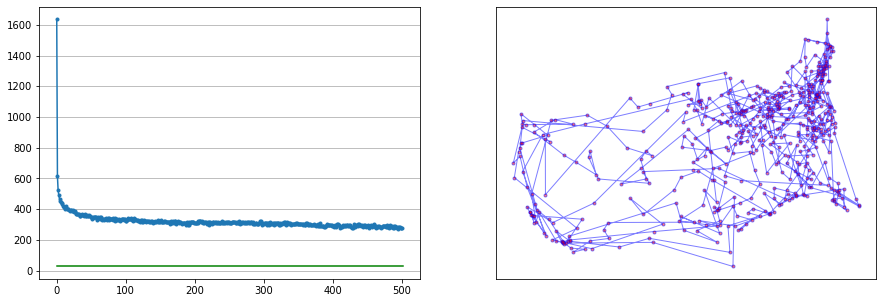

In [10]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

Great exercise. If there is one comment I would make is it was hard to follow what exactly the restrictions in code were in section 5.5